In [113]:
##
# notebook to analyze px4 ulog files
# data messages:
# vx: velocity in x (world NED)
# vy: velocity in y (world NED)
# vx_b_yaw: velocity in x (body NED without tilt)
# vy_b_yaw: velocity in y (body NED without tilt)
# v_airx: airspeed estimate in x (world NED)
# v_airy: airspeed estimate in y (world NED)
# v_airx_body_yaw: airspeed estimate in x (body NED without tilt)
# v_airy_body_yaw: airspeed estimate in y (body NED without tilt)
# baro_alt: barometric altitude - static altitude
###
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import glob
from px4tools import logdynamicpressure as ldp

In [114]:
# ulog filename
path = '/home/dennis/src/px4Analysis/log/altitude'
files = glob.glob(os.path.join(path,"*.ulg"))

In [115]:
# generate data
df = pd.DataFrame()
for file in files:
    data = ldp.load_data(file)
    data = ldp.estimate_airspeed(data)
    data = ldp.prepare_dynamicaltitude_data(data)
    df = df.append(data)
df.index = list(range(len(df))) 

In [116]:
data = pd.DataFrame({'X1': df.vx_b_yaw,
                    'X2': df.vy_b_yaw,
                     'X3': df.vx_b_yaw**2,
                     'X4': df.vy_b_yaw**2,
                        'Z':df.baro_alt})

In [117]:
model = ols("Z ~ X1 + X2 + X3 + X4", data).fit()

In [118]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Z   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     98.40
Date:                Mon, 13 Feb 2017   Prob (F-statistic):           3.50e-81
Time:                        22:31:07   Log-Likelihood:                -4995.7
No. Observations:                5863   AIC:                         1.000e+04
Df Residuals:                    5858   BIC:                         1.003e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.1031      0.009    -11.371      0.0

In [119]:
coeff = model._results.params
print(coeff)

[-0.10307199 -0.00178157  0.00309162  0.00322678  0.00360242]


/home/dennis/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


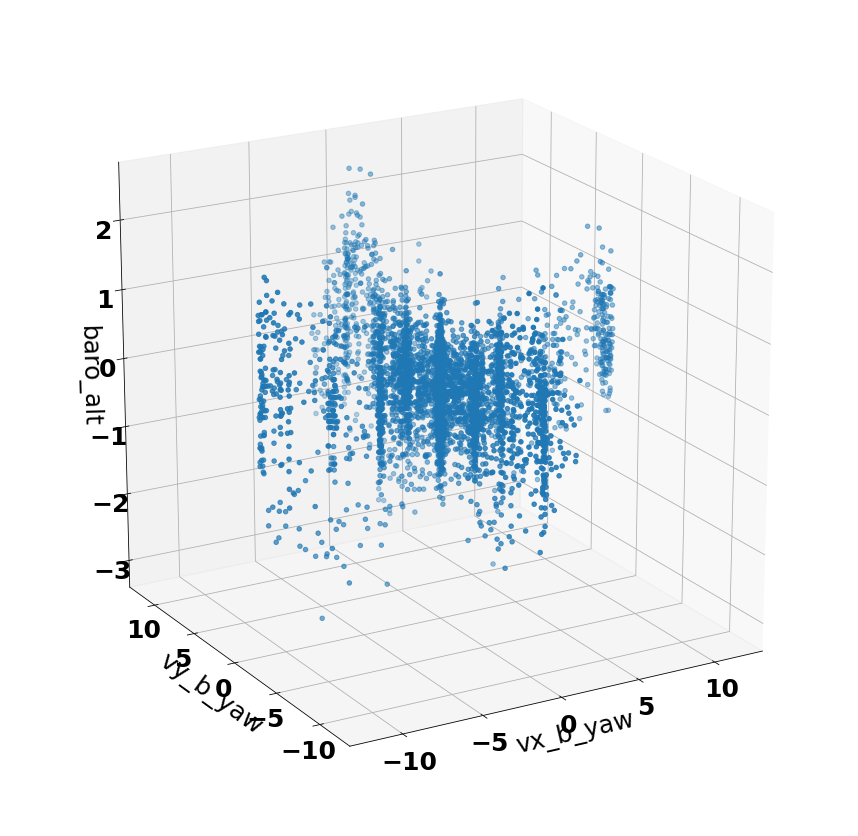

In [120]:
#plot data using ground velocity in body-yaw frame
fig = plt.figure(figsize=(15,15))
plt.rc('font', size=25)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
ax = fig.gca(projection='3d')
ax.scatter(df.vx_b_yaw, df.vy_b_yaw, df.baro_alt)
ax.view_init(20,-120)
ax.set_xlabel('vx_b_yaw')
ax.set_ylabel('vy_b_yaw')
ax.set_zlabel('baro_alt')
plt.show()

/home/dennis/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


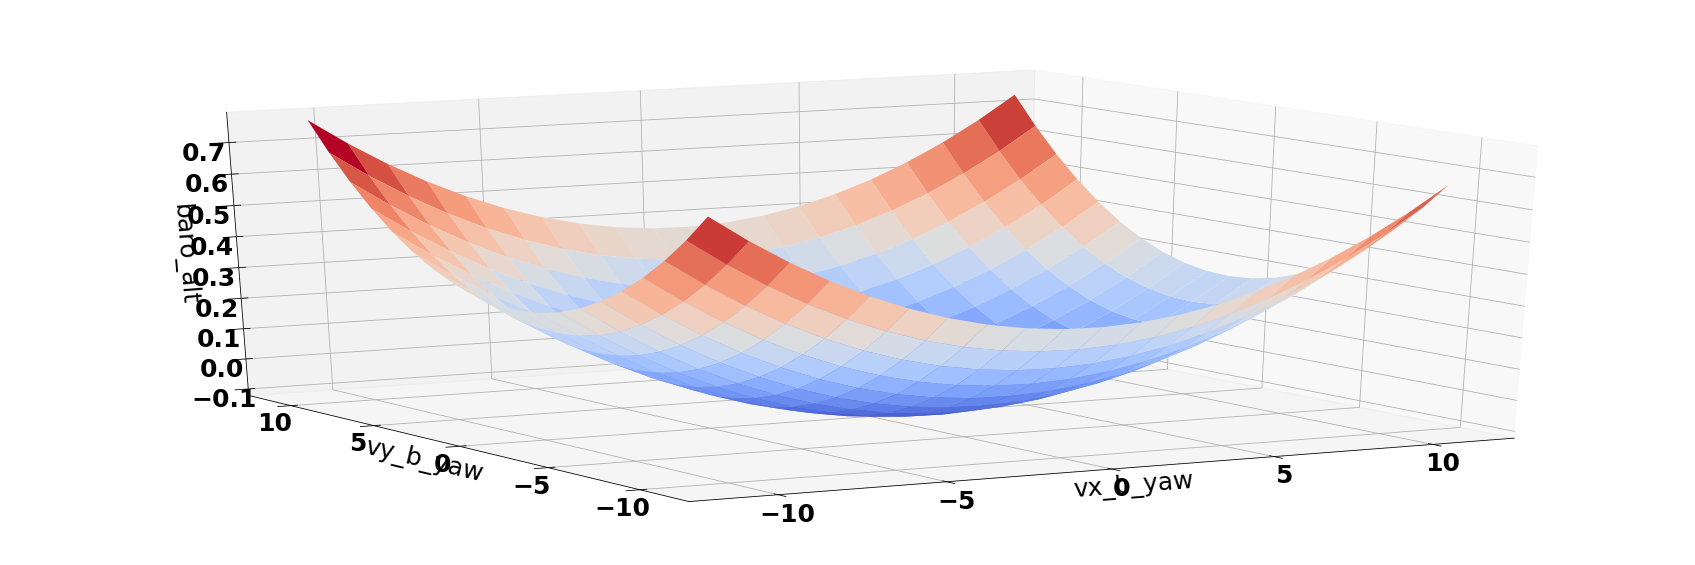

In [121]:
# generate data with new model
x = np.linspace(-11,11,20)
X,Y = np.meshgrid(x,x)
Z = coeff[0] + coeff[1]*X + coeff[2]*Y + coeff[3]*X**2 + coeff[4]*Y**2
fig = plt.figure(figsize=(30,10))
plt.rc('font', size=25)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,
                       rstride=1, cstride=1)
ax.view_init(20, -120)
ax.set_xlabel('vx_b_yaw')
ax.set_ylabel('vy_b_yaw')
ax.set_zlabel('baro_alt')
plt.show()